<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/pytorch_nn_barebones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Classification Example with PyTorch using nn module

## by Fayyaz Minhas

This is a "barebones" example with PyTorch nn module in which we train a simple neural network and visualize its decision boundary.

Let's load some visualization code first (You don't need to understand this part!).


In [1]:
from numpy.random import randn #importing randn
import numpy as np #importing numpy
import matplotlib.pyplot as plt #importing plotting module
import itertools
import warnings

def plotit(X,Y=None,clf=None,  conts = None, ccolors = ('b','k','r'), colors = ('c','y'), markers = ('s','o'), hold = False, transform = None,extent = None,**kwargs):
    """
    A function for showing data scatter plot and classification boundary
    of a classifier for 2D data
        X: nxd  matrix of data points
        Y: (optional) n vector of class labels
        clf: (optional) classification/discriminant function handle
        conts: (optional) contours (if None, contours are drawn for each class boundary)
        ccolors: (optional) colors for contours
        colors: (optional) colors for each class (sorted wrt class id)
            can be 'scaled' or 'random' or a list/tuple of color ids
        markers: (optional) markers for each class (sorted wrt class id)
        hold: Whether to hold the plot or not for overlay (default: False).
        transform: (optional) a function handle for transforming data before passing to clf
        kwargs: any keyword arguments to be passed to clf (if any)
    """
    if clf is not None and X.shape[1]!=2:
        warnings.warn("Data Dimensionality is not 2. Unable to plot.")
        return
    if markers is None:
        markers = ('.',)
    eps=1e-6
    d0,d1 = (0,1)
    if extent is None:
        minx, maxx = np.min(X[:,d0])-eps, np.max(X[:,d0])+eps
        miny, maxy = np.min(X[:,d1])-eps, np.max(X[:,d1])+eps
        extent = [minx,maxx,miny,maxy]
    else:
        [minx,maxx,miny,maxy] = extent
    if Y is not None:
        classes = sorted(set(Y))
        if conts is None or len(conts)<2:
            #conts = list(classes)
            vmin,vmax = classes[0]-eps,classes[-1]+eps
        else:
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps

    else:
        vmin,vmax=-2-eps,2+eps
        if conts is None or len(conts)<2:
            conts = sorted([-1+eps,0,1-eps])
        else:
            vmin,vmax= np.min(conts)-eps,np.max(conts)+eps

    if clf is not None:
        npts = 150
        x = np.linspace(minx,maxx,npts)
        y = np.linspace(miny,maxy,npts)
        t = np.array(list(itertools.product(x,y)))
        if transform is not None:
            t = transform(t)
        z = clf(t,**kwargs)

        z = np.reshape(z,(npts,npts)).T


        plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')
        #plt.imshow(np.flipud(z), extent = extent, cmap=plt.cm.Purples, vmin = -2, vmax = +2); plt.colorbar()
        plt.pcolormesh(x, y, z,cmap=plt.cm.Purples,vmin=vmin,vmax=vmax);plt.colorbar()
        plt.axis(extent)

    if Y is not None:
        for i,y in enumerate(classes):

            if colors is None or colors=='scaled':
                cc = np.array([[i,i,i]])/float(len(classes))
            elif colors =='random':
                cc = np.array([[np.random.rand(),np.random.rand(),np.random.rand()]])
            else:
                cc = colors[i%len(colors)]

            mm = markers[i%len(markers)]
            plt.scatter(X[Y==y,d0],X[Y==y,d1], marker = mm,c = cc, s = 50)

    else:
        plt.scatter(X[:,d0],X[:,d1],marker = markers[0], c = 'k', s = 5)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    if not hold:
        plt.grid()
        plt.show()
    return extent



Let's write some helper functions so that we can convert between numpy arrays and pytorch tensors and run our code on GPU!

In [2]:
import torch
import torch.optim as optim

USE_CUDA = torch.cuda.is_available()

def cuda(v):
    """
    Transfers the input tensor to the GPU if CUDA is available.

    Parameters:
    - v (torch.Tensor): The PyTorch tensor to transfer.

    Returns:
    - torch.Tensor: The tensor on the GPU if CUDA is available, else the tensor remains on the CPU.
    """
    if USE_CUDA:
        return v.cuda()
    return v

def toTensor(v, dtype=torch.float, requires_grad=False):
    """
    Converts a given value into a PyTorch tensor of the specified data type, with an option to require gradients.
    The resulting tensor is transferred to the GPU if CUDA is available.

    Parameters:
    - v (array-like or numeric): The value to be converted into a PyTorch tensor. Can be a list, a NumPy array, or a scalar.
    - dtype (torch.dtype, optional): The desired data type of the tensor (default: torch.float).
    - requires_grad (bool, optional): Whether the tensor requires gradients (default: False). Useful for backpropagation.

    Returns:
    - torch.Tensor: A PyTorch tensor of the specified data type, with gradients if required, possibly on the GPU.
    """
    return cuda(torch.tensor(v, dtype=dtype, requires_grad=requires_grad))

def toNumpy(v):
    """
    Converts a PyTorch tensor into a NumPy array. If the tensor is on the GPU, it is first moved to the CPU.

    Parameters:
    - v (torch.Tensor): The PyTorch tensor to convert.

    Returns:
    - numpy.ndarray: The converted NumPy array.
    """
    if USE_CUDA:
        return v.detach().cpu().numpy()
    return v.detach().numpy()

print('Using CUDA:', USE_CUDA)


Using CUDA: True


Let's make some data and a neural network.
We can train the neural network with PyTorch. Note that everything has to be pytorch tensor for it to work.

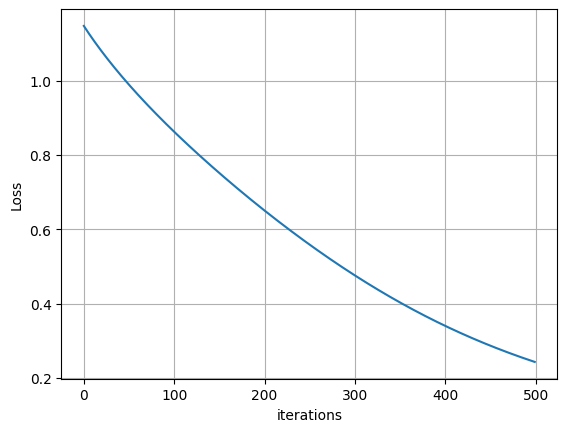

In [3]:
import numpy as np
inputs = np.array([[-1,0],[0,1],[4,4],[2,3]])
targets = np.array([-1,-1,+1,+1])
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
H, D_out = 2, 1
x = toTensor(inputs)
y = toTensor(targets)
N,D_in = x.shape
# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H),
    torch.nn.Sigmoid(),
    torch.nn.Linear(H, D_out),
)
model=cuda(model)
# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
L = []
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = model(x).flatten()
    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    L.append(loss.item())
    # Zero the gradients before running the backward pass.
    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    model.zero_grad()
    loss.backward()
    optimizer.step()
plt.plot(L);plt.xlabel('iterations');plt.ylabel('Loss');plt.grid()

Let's print the outputs:

In [4]:
print(y_pred)

tensor([-0.8825, -0.3380,  0.5484,  0.4367], device='cuda:0',
       grad_fn=<ViewBackward0>)


<ipython-input-1-2589d046d203>:63: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(x,y,z,conts,linewidths = [2],colors=ccolors,extent=extent, label='f(x)=0')


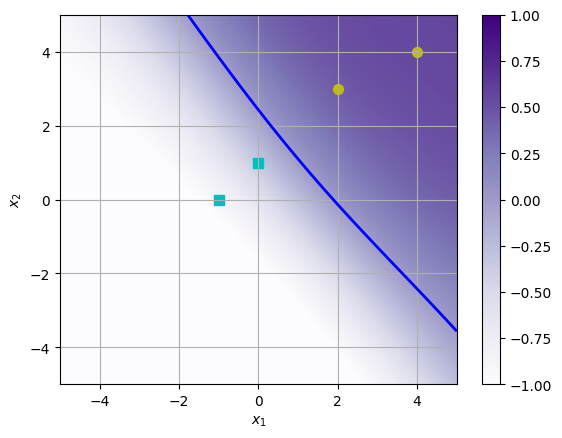

[-5, 5, -5, 5]

In [5]:
def clf(x):
    model.eval()
    return toNumpy(model(toTensor(x)))
plotit(inputs,targets,clf=clf,conts=[0],extent = [-5,+5,-5,+5])